In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold  #閾値(self.alphasから書き換える）
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_reset(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        ell_obs, phi_obs = values
        
        pos = self.map.landmarks[landmark_id].pos
        for p in self.particles:        
            ori = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs()
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs()

            p.pose[0] = pos[0] + ell*math.cos(ori)
            p.pose[1] = pos[1] + ell*math.sin(ori)
            p.pose[2] = math.atan2(pos[1]-p.pose[1], pos[0]-p.pose[0]) - phi
            p.weight = 1.0/len(self.particles)
    
    def resetting(self, observation): #引数を追加
        self.sensor_reset(observation) #sensor_resetの呼び出しに変更
        
    def observation_update(self, observation):
        if observation == []: #追加
            return
        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.resetting(observation)  #引数追加
        else:
            self.resampling() 

<IPython.core.display.Javascript object>


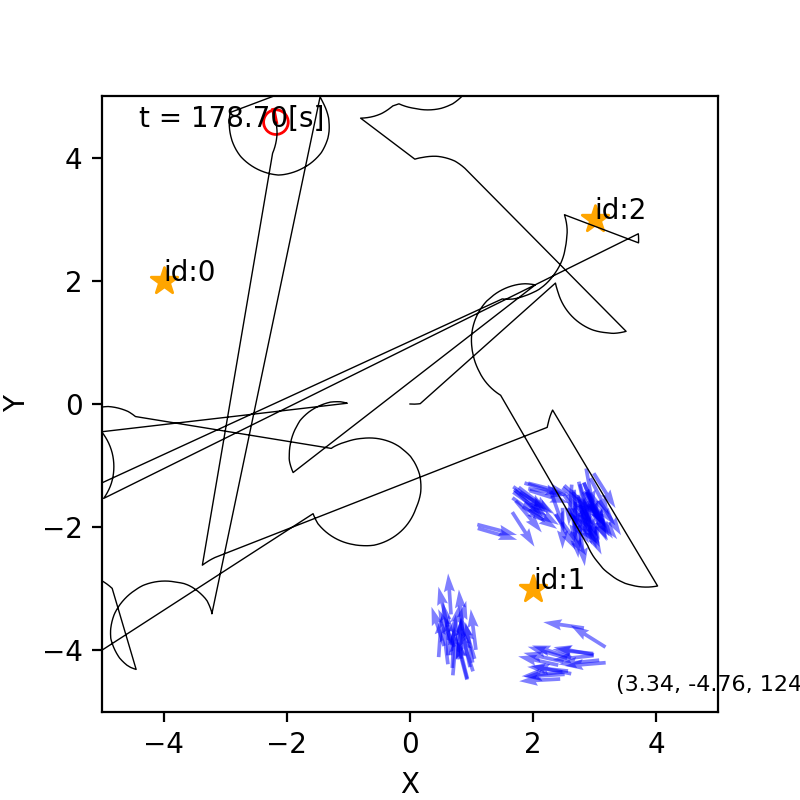

In [3]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = World(300, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()                                  
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)          

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T
    pf = ResetMcl(m, initial_pose, 100)
    circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
#  r = Robot(initial_pose, sensor=Camera(m), agent=circling, color="red")   #誘拐なし
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling, expected_kidnap_time=10.0, color="red") #誘拐あり
    world.append(r)

    world.draw()
#    world.ani.save('/tmp/anm.gif', writer='imagemagick', fps=1)

In [4]:
np.pi

3.141592653589793